# Spark ML Challenge 3 : Predicting Bike Rental

### Group G
Theo, Amartya, Charlotte, Hernando, Camillo, Rui, Vilhelm

### Description
Bike sharing is a service provided now by several major cities around the world. Data is
regularly and automatically collected on this services by the renting system. Analyzing it can
help predict usage levels and effectively provide a ‘map‘ of the city traffic activity and hot
spots. The dataset corresponds to Washington DC​ but many equivalent datasets are available
for other cities , including Madrid​.

### Objective:
Build a predictive model capable of predicting the total number of bike rentals per hour for a
given weekday. Note​ you may also want to add weather information to improve model
accuracy, i.e , be able to predict nb of bike rentals per hour for weekday and weather
conditions , or even add more features ( like e.g. : bank holidays information )

**Plan:**
1. Import data
2. Data Pre-processing
3. Merge dataset
4. Inspect data
5. Correlation
6. Data Engineering
7. Feature Selection
8. Modelling
9. Evaluation


### Input Dataset Details:
Data Volume : < 6 GB
Data files:
- bikes_data_names ​A list of features corresponding to the bike rental data
- bike rental data : ​Bike Trip data files set in the format of single files :YYYY_qN_trip_history_data.csv
- weather_data_names ​A list of features corresponding to the weather data
- weather data : weather_data_daily.csv ​weather data (resolution 1 day)

### Import Libaries

In [1]:
# import selected libaries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyspark
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F
from  pyspark.sql.functions import abs
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import date_format
from pyspark.sql import SparkSession
import seaborn as sns

### Set Directories

In [2]:
# define home directory
my_home=os.environ['HOME']

In [3]:
# define dataset directory
full_dataset_path = 'spark-course/challenge_3/'

In [4]:
# define test dataset directory -> 2013 & 2014
test_dataset_path = 'spark-course/challenge_3/test_year/'

In [5]:
# define weather file directory
weather_file_path = 'other/'

### Initialize Spark

In [6]:
# Create a SparkSession and specify configuration
spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Spark_Final_Assignment_N3") \
    .enableHiveSupport() \
    .getOrCreate()

In [7]:
# view current spark version
spark.version

'2.2.0'

### Import Data

#### Trip data

In [8]:
# use SparkSession and infer schema with header (messy header names so we exchange with predefined ones)
# import all trip data csvs
df_trip = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("file:///"+full_dataset_path+"*.csv")
    
# define name of features    
trip_features = [ 'duration_ms', 'start_date', 'end_date','start_station_nr', 'start_station', \
                 'end_station_nr', 'end_station', 'bike_nr', 'member_type'] 

# define current names
rawnames = df_trip.schema.names

# Define function for chaning column names
def updateColNames(df, oldnames, newnames):
    for i in range(len(newnames)):
        df=df.withColumnRenamed(oldnames[i], newnames[i])
    return df

# Run function and redefine df
df_trip=updateColNames(df_trip, rawnames, trip_features)

# View schema with new names
df_trip.printSchema()

root
 |-- duration_ms: integer (nullable = true)
 |-- start_date: timestamp (nullable = true)
 |-- end_date: timestamp (nullable = true)
 |-- start_station_nr: string (nullable = true)
 |-- start_station: string (nullable = true)
 |-- end_station_nr: string (nullable = true)
 |-- end_station: string (nullable = true)
 |-- bike_nr: string (nullable = true)
 |-- member_type: string (nullable = true)



In [9]:
# inspect first row -> columns names very long thus bad view
df_trip.show(1)

+-----------+-------------------+-------------------+----------------+-------------+--------------+-------------------+-------+-----------+
|duration_ms|         start_date|           end_date|start_station_nr|start_station|end_station_nr|        end_station|bike_nr|member_type|
+-----------+-------------------+-------------------+----------------+-------------+--------------+-------------------+-------+-----------+
|     356376|2014-07-01 00:01:18|2014-07-01 00:07:14|           31408| Takoma Metro|         32011|Maple & Ritchie Ave| W20813|     Member|
+-----------+-------------------+-------------------+----------------+-------------+--------------+-------------------+-------+-----------+
only showing top 1 row



In [10]:
# Cache trip_df
df_trip.cache()

DataFrame[duration_ms: int, start_date: timestamp, end_date: timestamp, start_station_nr: string, start_station: string, end_station_nr: string, end_station: string, bike_nr: string, member_type: string]

In [11]:
# Create a temporary in-memory DataFrame -> for usage with SparkSQL
df_trip.registerTempTable("df_trip")

#### Weather data

In [12]:
# use SparkSession and infer schema, then add a header (file do not contain headers)
# import weather data csv
df_weather = spark.read \
    .option("inferSchema", "true") \
    .csv("file:///"+full_dataset_path+weather_file_path+"*.csv")
    
# define name of features    
weather_features = [ 'site4', 'date', 'source','max_temp','avg_temp', 'hdds', \
                      'cdds', 'precipitation', 'snowfall', 'snow_ice_depth', 'random']

# define current names
rawnames = df_weather.schema.names

# Create a small function for chaning name
def updateColNames(df,oldnames,newnames):
    for i in range(len(newnames)):
        df=df.withColumnRenamed(oldnames[i], newnames[i])
    return df

# Run function and redefine df
df_weather=updateColNames(df_weather,rawnames,weather_features)

# View schema with new names
df_weather.printSchema()

root
 |-- site4: string (nullable = true)
 |-- date: string (nullable = true)
 |-- source: string (nullable = true)
 |-- max_temp: integer (nullable = true)
 |-- avg_temp: integer (nullable = true)
 |-- hdds: double (nullable = true)
 |-- cdds: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snowfall: double (nullable = true)
 |-- snow_ice_depth: double (nullable = true)
 |-- random: double (nullable = true)



In [13]:
# Count rows of weather data
df_weather.count()

2922

In [14]:
# Cache weather df
df_weather.cache()

DataFrame[site4: string, date: string, source: string, max_temp: int, avg_temp: int, hdds: double, cdds: double, precipitation: double, snowfall: double, snow_ice_depth: double, random: double]

In [15]:
#  Create a temporary in-memory DataFrame for Spark-SQL
df_weather.registerTempTable("df_weather")

### Data Pre-processing

**Trip Data**
1. Drop irrelevant columns.
2. Convert duration_ms to duration_min.
3. Remove +/- 2sd from duration_min.
5. Drop 'fake trips' i.e. start and end station same and duration less than 5min.
6. Split start_date to get start_date and start_time.
7. Split start_time to get start_hour.
8. Group data by date and hour.

**Weather Data**
1. Drop irrelevant columns.
2. Transfrom date to same format as start_date_1

#### Trip Data

#### 1. Drop irrelevant columns

In [16]:
# define query to select features
query = 'SELECT duration_ms, start_date, \
                end_date, start_station_nr, \
                end_station_nr \
         FROM df_trip'

# run query
df_trip_sub = spark.sql(query)

#### 2. Convert duration_ms to duration_min

In [17]:
# Convert duration ms to minutes by dividing by 60000 (ms / 1000 -> to sec / 60 -> to min)
df_trip_sub = df_trip_sub.withColumn('duration_min', df_trip_sub.duration_ms / 60000)

#### 3. Remove +/- 2sd from duration_min

In [18]:
df_tmp = df_trip_sub['duration_min']
mean = df_trip_sub.agg({'duration_min': 'avg'}).collect()[0][0]
std = df_trip_sub.agg({'duration_min': 'std'}).collect()[0][0]

df_trip_sub = df_trip_sub.select('duration_min', 'start_date', 'end_date',
                                 'start_station_nr', 'end_station_nr') \
                         .filter(abs(df_tmp - mean) < 2 * std)

#### 4. Drop 'fake trips'

In [19]:
df_trip_sub = df_trip_sub.select('duration_min', 'start_date', 'end_date') \
                         .filter((df_trip_sub['duration_min'] > 5) & \
                                 (df_trip_sub['start_station_nr'] != \
                                  df_trip_sub['end_station_nr']))

#### 5. Split start_date -> start_date_1 and start_time

In [20]:
# define split 
split_col = pyspark.sql.functions.split(df_trip_sub['start_date'], ' ')

# get split start_date_1
df_trip_sub = df_trip_sub.withColumn('start_date_1', split_col.getItem(0))
# get split start_time
df_trip_sub = df_trip_sub.withColumn('start_time', split_col.getItem(1))

#### 6. Split start_time -> start_hour

In [21]:
# define split 
split_col = pyspark.sql.functions.split(df_trip_sub['start_time'], ':')

# get split start_date_1
df_trip_sub = df_trip_sub.withColumn('start_hour', split_col.getItem(0))

#### 7. Data grouping
Groupby start day and start hour with mean duration and count

In [22]:
df_trip_sub = df_trip_sub.groupby('start_date_1', 'start_hour') \
                         .agg(F.count('end_date').alias('count'), \
                              F.avg('duration_min').alias('avg_duration')) \
                         .orderBy('start_date_1', 'start_hour', ascending = False)

In [23]:
# count rows
df_trip_sub.count()

63055

In [24]:
# Cache df
df_trip_sub.cache()

DataFrame[start_date_1: string, start_hour: string, count: bigint, avg_duration: double]

In [25]:
#  Create a temporary in-memory DataFrame for Spark-SQL
df_trip_sub.registerTempTable("df_trip_sub")

#### Weather Data

#### 1. Drop irrelevant columns

In [26]:
# Select important features
df_weather = df_weather.select('date', 'max_temp', 'avg_temp', \
                              'precipitation', 'snowfall', 'snow_ice_depth')

#### 2. Transfrom date format

In [27]:
# convert date to unix format
df_weather = df_weather.select('max_temp', 'avg_temp', \
                  'precipitation', 'snowfall', 'snow_ice_depth', \
                  from_unixtime(unix_timestamp('date', 'MM/dd/yyy')).alias('date'))

In [28]:
# define split 
split_col = pyspark.sql.functions.split(df_weather['date'], ' ')

# get split date_1
df_weather = df_weather.withColumn('date', split_col.getItem(0))

In [29]:
# Cache weather df
df_weather.cache()

DataFrame[max_temp: int, avg_temp: int, precipitation: double, snowfall: double, snow_ice_depth: double, date: string]

In [30]:
#  Create a temporary in-memory DataFrame for Spark-SQL
df_weather.registerTempTable("df_weather")

### Merge Data 
1. Merge df_trip_sub with df_weather by date

In [31]:
# merge dfs
df_all = spark.sql('SELECT * FROM df_trip_sub \
                   LEFT JOIN df_weather \
                   ON df_trip_sub.start_date_1 = df_weather.date')

In [32]:
# count rows
df_all.count()

63055

In [33]:
# show columns
df_all.columns

['start_date_1',
 'start_hour',
 'count',
 'avg_duration',
 'max_temp',
 'avg_temp',
 'precipitation',
 'snowfall',
 'snow_ice_depth',
 'date']

In [34]:
# Cache df
df_all.cache()

DataFrame[start_date_1: string, start_hour: string, count: bigint, avg_duration: double, max_temp: int, avg_temp: int, precipitation: double, snowfall: double, snow_ice_depth: double, date: string]

In [35]:
#  Create a temporary in-memory DataFrame for Spark-SQL
df_all.registerTempTable("df_all")

### Data Processing
1. Add day of the week to df_all
2. Transform start_hour from string to int.
3. Look for missing values.

#### 1. Add week of the day 

In [36]:
# add feature day of the week
df_all = df_all.select('start_date_1', 'start_hour', 'count', \
             'avg_duration', 'max_temp', 'avg_temp', \
             'precipitation', 'snowfall','snow_ice_depth', \
              date_format('start_date_1', 'E').alias('day_of_week'))

#### 2. Convert start_hour to int

In [37]:
# change start_hour form string to int
df_all = df_all.withColumn("start_hour", df_all["start_hour"].cast('int'))

#### 3. Treat missing values

In [38]:
# look for missing values
df_all.toPandas().isnull().sum()

start_date_1       0
start_hour         0
count              0
avg_duration       0
max_temp           0
avg_temp           0
precipitation      0
snowfall           0
snow_ice_depth    48
day_of_week        0
dtype: int64

In [39]:
# drop NaNs 
df_all = df_all.na.drop()

In [40]:
# inspect results
df_all.toPandas().isnull().sum()

start_date_1      0
start_hour        0
count             0
avg_duration      0
max_temp          0
avg_temp          0
precipitation     0
snowfall          0
snow_ice_depth    0
day_of_week       0
dtype: int64

### Data Inspection
1. Inspect weather data
2. Inspect bike data
3. Subset for numerical features
4. Compute correlations for numerical features
5. Visual inspection 

In [41]:
# describe weather paramenters
df_all.select('max_temp', 'precipitation', 'snowfall', 'snow_ice_depth').describe().show()

+-------+------------------+-----------------+-------------------+--------------------+
|summary|          max_temp|    precipitation|           snowfall|      snow_ice_depth|
+-------+------------------+-----------------+-------------------+--------------------+
|  count|             63007|            63007|              63007|               63007|
|   mean| 66.42341327154126|3.493500722141984|0.10900981160823407|0.048625073404542314|
| stddev|18.154156785046155|5.580150137498256| 0.3139070335205244| 0.47088381980781774|
|    min|                15|              0.0|                0.0|                 0.0|
|    max|               105|             25.5|               4.74|                11.7|
+-------+------------------+-----------------+-------------------+--------------------+



In [42]:
# describe bike parameters
df_all.select('count', 'avg_duration').describe().show()

+-------+------------------+------------------+
|summary|             count|      avg_duration|
+-------+------------------+------------------+
|  count|             63007|             63007|
|   mean|244.14042884123987| 14.68291670561939|
| stddev|   266.34930793509|3.5432817577889106|
|    min|                 1|            5.0025|
|    max|              1747|           79.9471|
+-------+------------------+------------------+



In [43]:
# create subset for numerical features
df_numerical = df_all.select('count', 'avg_duration', 'max_temp', 'start_hour', \
                             'precipitation', 'snowfall', 'snow_ice_depth')

#### Correlation

In [44]:
# function that computes the correlation of each column against the target
# Computes Pearson Correlation Coefficient between the two columns
def computeCorrelation(df, targetColumnName):
    for col in df.columns:
        r=df.stat.corr(col, targetColumnName)
        print("Pearson correlation : %s %s %f \n" %(col, targetColumnName , r))

In [45]:
# get correlation against bike count
computeCorrelation(df_numerical, 'count')

Pearson correlation : count count 1.000000 

Pearson correlation : avg_duration count 0.330365 

Pearson correlation : max_temp count 0.288379 

Pearson correlation : start_hour count 0.328915 

Pearson correlation : precipitation count 0.157065 

Pearson correlation : snowfall count -0.086651 

Pearson correlation : snow_ice_depth count -0.068109 



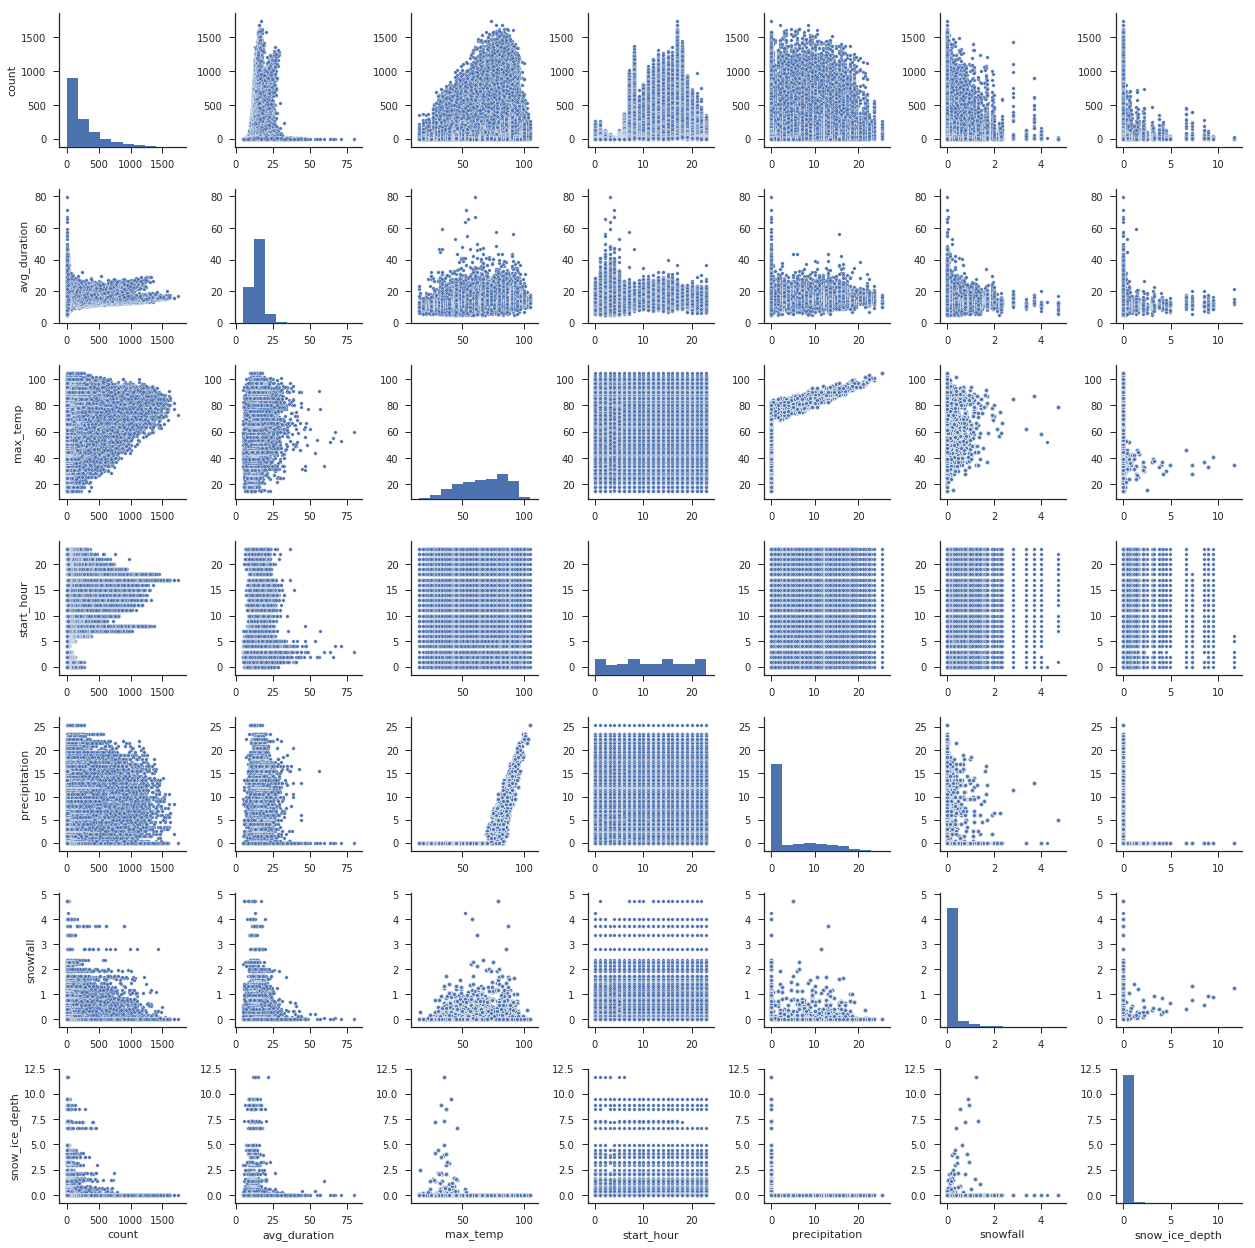

In [46]:
# Visualize correlations
sns.set(style="ticks", color_codes=True )
sns.pairplot(df_numerical.toPandas(), markers=".")
plt.show()

### Data Engineering
1. Look at distrubution of start_hour against count
2. Binning

#### start_hour

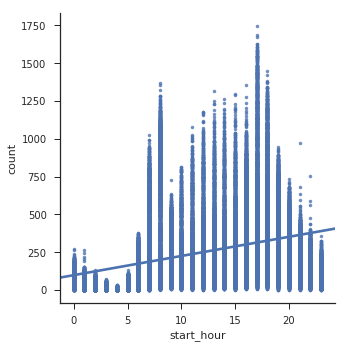

In [47]:
sns.lmplot("start_hour", "count", data=df_all.toPandas(), fit_reg=True, markers=".")
plt.show();

#### start_hour binning
- bin 1: 22:00-05:59
- bin 2: 06:00-09:59
- bin 3: 10:00-17:59
- bin 3: 18:00-21:59

In [48]:
# create bins for start_hour
from pyspark.sql.functions import when

df_all = df_all.withColumn("hour_bin_1", when(((df_all['start_hour'] >= 22) \
                                               | (df_all['start_hour'] < 6)), 1).otherwise(0))

df_all = df_all.withColumn("hour_bin_2", when(((df_all['start_hour'] <= 10) & \
                                                (df_all['start_hour'] > 6)), 1).otherwise(0))

df_all = df_all.withColumn("hour_bin_3", when(((df_all['start_hour'] >= 10) & \
                                                (df_all['start_hour'] < 18)), 1).otherwise(0))

df_all = df_all.withColumn("hour_bin_4", when(((df_all['start_hour'] >= 18) & \
                                                (df_all['start_hour'] < 22)), 1).otherwise(0))       

#### binning weekday
- weekday bin: Mon-Fri 
- weekend bin: Sat-Sun

In [49]:
# create bins for start_hour
from pyspark.sql.functions import when

df_all = df_all.withColumn("weekday", 
                           when(((df_all['day_of_week'] != 'Sat') & \
                                 (df_all['day_of_week'] != 'Sun')), 1).otherwise(0))

df_all = df_all.withColumn("weekend", when(((df_all['day_of_week'] == 'Sat') | \
                                            (df_all['day_of_week'] == 'Sun')), 1).otherwise(0))

#### binning season
- summer bin: apr-oct (04-10)
- winter bin: nov-mar (11-03)

In [50]:
# create bins for start_hour
from pyspark.sql.functions import when

# define split 
split_col = pyspark.sql.functions.split(df_all['start_date_1'], '-')

# get split start_date_1
df_all = df_all.withColumn('month', split_col.getItem(1))

# change start_hour form string to int
df_all = df_all.withColumn("month", df_all["month"].cast('int'))


df_all = df_all.withColumn("summer", 
                           when(((df_all['month'] > 3) & \
                                 (df_all['month'] < 11)), 1).otherwise(0))

df_all = df_all.withColumn("winter", when(((df_all['month'] < 3) | \
                                            (df_all['month'] > 11)), 1).otherwise(0))

### Feature Selection

In [51]:
# select features for regression model (inc. target)
df_reg = df_all.select('count', 'max_temp', 'precipitation', 'snowfall', \
                      'weekday', 'weekend', 'hour_bin_1', 'hour_bin_2', 'hour_bin_3', 'hour_bin_4', \
                      'summer', 'winter')

#### Convert df to label and features vectors

In [52]:
# Define the input_data 
# The count (row[0]) is our target variable (the label)
# The rest of the values row[1:] our our features
data = df_reg.rdd.map(lambda row: (row[0], DenseVector(row[1:])))

# Replace df with the new DataFrame
df = spark.createDataFrame(data, ["label", "features"])

### Data Splitting

In [53]:
# Split the data into train and test sets
train_data, test_data = df.randomSplit([.8, .2],seed= 1234)
print('Training records : %d' % train_data.count())
print('Test records : %d ' % test_data.count())

Training records : 50523
Test records : 12484 


### Model Creation

In [54]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="label", maxIter=10, elasticNetParam=0.8)

# Fit the data to the models
linearModelA = lr.fit(train_data,{lr.regParam:0.1})
linearModelB = lr.fit(train_data,{lr.regParam:0.3})
linearModelC = lr.fit(train_data,{lr.regParam:0.6})
linearModelD = lr.fit(train_data,{lr.regParam:0.9})

# Generate predictions for models
predictedA = linearModelA.transform(test_data)
predictedB = linearModelB.transform(test_data)
predictedC = linearModelC.transform(test_data)
predictedD = linearModelD.transform(test_data)

### Model Evaluation

In [55]:
# Get the RMSE ( standard deviation of the residuals ) residual = predicted - observed
linearModelA.summary.rootMeanSquaredError

209.82397609408608

In [56]:
# The R2 (coefficient of determination) is a measure 
linearModelA.summary.r2

0.37783495603355177

In [57]:
linearModelB.summary.r2

0.377873379465696

In [58]:
linearModelC.summary.r2

0.37784068777704993

In [59]:
linearModelD.summary.r2

0.3778191906916345

#### Quit Spark

In [60]:
spark.stop()

### Conclusion
We managed to aggregate 19 million rows into a format wherein we managed to produce a linear regression model. The four models show similar R2 score from where we can conclude that the regularization parameter do not help us. We most likely don't have an issue with overfitting. Our features are simply not enough, linear speakling, to describe our target, count of bike rental per given day and hour.

**Suggestions**
- Scalling and log-transformation to remove skewness
- Try more complex models i.e. RF / GBM
- Introduce more features i.e. bank-holidays